In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

In [2]:
points = np.linspace(0, 10*np.pi, 20000)
df = np.sin(points)+np.sin(points*5)+np.sin(points/10)
df = pd.DataFrame(df, columns=['Value'])
timeseries = df[["Value"]].values.astype('float32')
len(timeseries)

20000

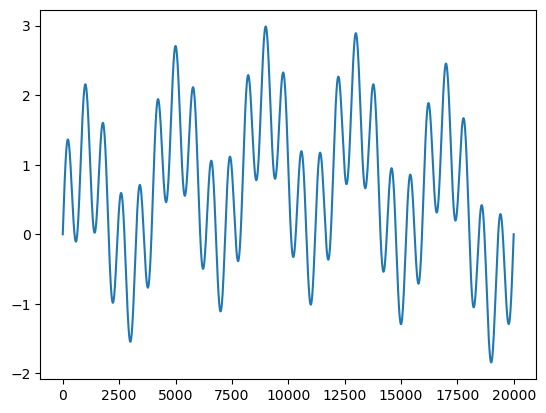

In [3]:
plt.plot(timeseries)
plt.show()

In [4]:
# train-test split for time series
train_size = int(len(timeseries) * 0.67)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

In [10]:
import torch
device = torch.cuda.set_device(0)
def create_dataset(dataset, lookback):
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        # target = dataset[i+1:i+lookback+1]
        target = dataset[i+lookback]
        X.append(feature)
        y.append(target)
    return torch.tensor(X).to(device), torch.tensor(y).to(device)

In [11]:
device

In [12]:
lookback = 20
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([13380, 20, 1]) torch.Size([13380, 1])
torch.Size([6580, 20, 1]) torch.Size([6580, 1])


In [13]:
import torch.nn as nn

class SineModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        x = self.linear(x)
        return x

In [14]:
import numpy as np
import torch.optim as optim
import torch.utils.data as data

model = SineModel().to(device)
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=1024)

n_epochs = 200
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 10 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = torch.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = torch.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 1.0610, test RMSE 0.9381
Epoch 10: train RMSE 0.0618, test RMSE 0.1187
Epoch 20: train RMSE 0.0329, test RMSE 0.0570
Epoch 30: train RMSE 0.0286, test RMSE 0.0445
Epoch 40: train RMSE 0.0246, test RMSE 0.0370
Epoch 50: train RMSE 0.0223, test RMSE 0.0323
Epoch 60: train RMSE 0.0183, test RMSE 0.0268
Epoch 70: train RMSE 0.0143, test RMSE 0.0209
Epoch 80: train RMSE 0.0134, test RMSE 0.0175
Epoch 90: train RMSE 0.0087, test RMSE 0.0130
Epoch 100: train RMSE 0.0079, test RMSE 0.0115
Epoch 110: train RMSE 0.0070, test RMSE 0.0107
Epoch 120: train RMSE 0.0064, test RMSE 0.0101
Epoch 130: train RMSE 0.0058, test RMSE 0.0097
Epoch 140: train RMSE 0.0050, test RMSE 0.0082
Epoch 150: train RMSE 0.0043, test RMSE 0.0076
Epoch 160: train RMSE 0.0040, test RMSE 0.0073
Epoch 170: train RMSE 0.0035, test RMSE 0.0070
Epoch 180: train RMSE 0.0035, test RMSE 0.0066
Epoch 190: train RMSE 0.0037, test RMSE 0.0068


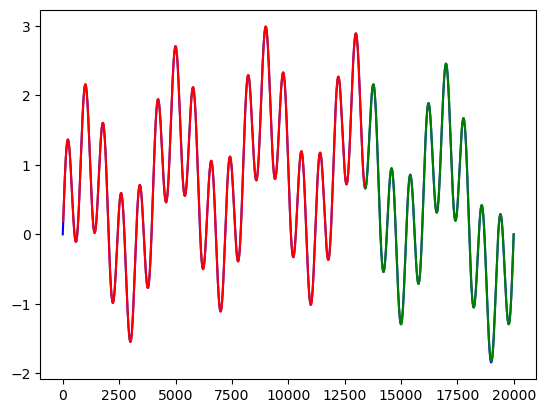

In [15]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    train_plot[lookback:train_size] = model(X_train).cpu()[:, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test).cpu()[:, :]
# plot
plt.plot(timeseries, c='b')
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()

In [16]:
x = X_test[0].cpu().numpy()
ar_points = []
for i in range(5000):
    with torch.no_grad():
        new_point = model(torch.Tensor(x.reshape(1, lookback, 1)).to(device)).cpu().numpy()[0][0]
    ar_points.append(new_point)
    x = np.concatenate([x[1:], [[new_point]]])

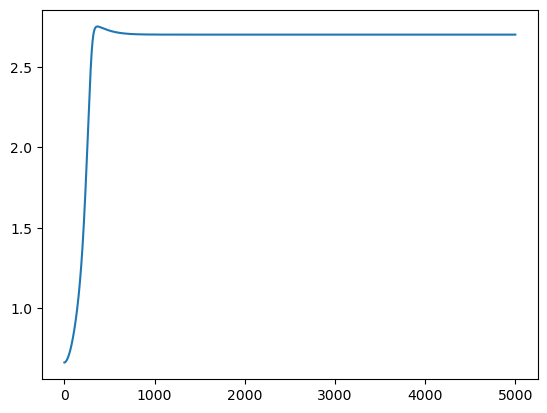

In [17]:
plt.plot(ar_points)